In [270]:
import os
import json
import pandas as pd
import numpy as np
import json
import logging ### to monitor the code
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
from urllib.request import urlopen 
import io
import getpass
import re
from collections import defaultdict
from itertools import islice # to iterate through dicts

import nltk
from nltk.collocations import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

import sddk

In [271]:
#from anda import gr
# OR uncomment the following:
script_url = "https://raw.githubusercontent.com/sdam-au/anda_py/master/anda/gr.py"
exec(requests.get(script_url).content)

In [272]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [273]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

ECCE_AGT_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KPpPaeX215HR_fVrakvJp8aB6oZDhHFTcBw0MKLw6as/edit?usp=sharing")

# Import the data

In [274]:
AGT = sddk.read_file("SDAM_data/AGT/AGT_20201027.json", "df", conf)
AGT.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,lemmata,lemmata_wordcount,lemmatized_sentences,n_sentences,tlg_epithet
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ...",3230,Epici/-ae
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶ...,150126,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68154,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...",6057,Historici/-ae
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,110773,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,"[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",55323,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...",9906,Biographi
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα...,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότη...",12177,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότ...",1725,Bucolici
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλο...",1089,"[[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλ...",135,Bucolici


In [275]:
len(AGT)

1457

In [276]:
AGT["wordcount"].sum()

33419267

In [277]:
len(AGT[AGT["date_avr"]< 4])

1255

In [278]:
AGT[AGT["date_avr"]< 4]["wordcount"].sum()

22355950

# δικ* over the whole corpus

In [279]:
# whole corpus as a list of lemmata
AGT_lemmata_list = np.concatenate(AGT["lemmata"].tolist())
len(AGT_lemmata_list)

13926141

In [280]:
match_pattern = "(κατα|ὑπό|ἐκ|ἀ|ἄ|ἀντί|^)δ[ι|ί]κ(α|ά|ο|ό|ί|έ|η)(.+)?"

dik_words = [word for word in AGT_lemmata_list if re.search(match_pattern, word)]
dik_words_df = pd.DataFrame(nltk.FreqDist(dik_words).most_common(), columns=["lemma", "count"])
dik_words_df.head(5)

,lemma,count
0,δίκαιος,14705
1,δίκη,6591
2,δικαιοσύνη,4409
3,ἀδικέω,4115
4,ἄδικος,3961


In [281]:
dik_words_df["translation"] = dik_words_df["lemma"].apply(lemma_translator)
dik_words_df.head(12)

,lemma,count,translation
0,δίκαιος,14705,"observant of custom and social rule, well-orde..."
1,δίκη,6591,"custom, usage"
2,δικαιοσύνη,4409,"righteousness, justice"
3,ἀδικέω,4115,to do wrong
4,ἄδικος,3961,"wrong-doing, unrighteous, unjust"
5,δικαστής,2450,a judge
6,ἀδικία,2067,"wrong-doing, injustice"
7,δικαστήριον,1339,a court of justice
8,ἀδίκημα,984,"a wrong done, a wrong"
9,δικάζω,932,"to judge, to give judgment on"


In [282]:
set_with_dataframe(ECCE_AGT_overview.add_worksheet("dik_words_20201027", 1,1), dik_words_df)

# Chronological overview

In [283]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη"]

In [284]:
def count_words_in_df_column(docs, words, wordcount=None):
    '''
    Parameters
    ----------
    docs : `pandas.Series` consisting of lists
        List or series of lists, each list representing a tokenized (and lemmatized) version of a document
    words : `list`
        List of words to be counted
    
    Returns
    -------
    `dict`
        Dictionary of word : count pairs
    '''
    counts_dict = {}
    weighted_sum = 0
    for word in words:
        count = docs.apply(lambda doc_list: doc_list.count(word)).sum()
        counts_dict[word] = count
        if wordcount != None:
            if wordcount > 0:
                weighted = np.round(count / wordcount, 5)
                counts_dict[word + "_weighted"] = weighted
                weighted_sum += weighted
    counts_dict["weighted_sum"] = weighted_sum
    return counts_dict

In [285]:
dates_list = [date / 100 for date in range(-750, 400, 50)]
print(dates_list)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [286]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [287]:
date_avr_to_string(0.0)

'1 BCE/1 CE'

In [288]:
date_avr_to_string(0.5)

'1 CE'

In [289]:
subselections = []
for date in dates_list:
    subselection = AGT[AGT["date_avr"]== date]
    wordcount_christian = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]=="christian")]["wordcount"].sum()
    wordcount_pagan = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]!="christian")]["wordcount"].sum()
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount, "wordcount_christian" : wordcount_christian, "wordcount_pagan" : wordcount_pagan, "doccount": doccount}
    subselection_dict.update(count_words_in_df_column(subselection["lemmata"], words, wordcount))
    subselections.append(subselection_dict)

In [290]:
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,wordcount_christian,wordcount_pagan,doccount,δίκαιος,δίκαιος_weighted,δίκη,δίκη_weighted,δικαιοσύνη,δικαιοσύνη_weighted,weighted_sum
0,8 BCE,date_avr,-7.5,199837,0,199837,3,16,0.00008,15,0.00008,0,0.00000,0.00016
1,8/7 BCE,date_avr,-7.0,16193,0,16193,3,8,0.00049,30,0.00185,0,0.00000,0.00234
2,7 BCE,date_avr,-6.5,144,0,144,1,0,0.00000,0,0.00000,0,0.00000,0.00000
3,7/6 BCE,date_avr,-6.0,9316,0,9316,3,1,0.00011,2,0.00021,0,0.00000,0.00032
4,6 BCE,date_avr,-5.5,39849,0,39849,2,23,0.00058,11,0.00028,2,0.00005,0.00091
5,6/5 BCE,date_avr,-5.0,66272,0,66272,14,46,0.00069,144,0.00217,0,0.00000,0.00286
6,5 BCE,date_avr,-4.5,558874,0,558874,35,432,0.00077,361,0.00065,9,0.00002,0.00144
7,5/4 BCE,date_avr,-4.0,1558696,0,1558696,197,1693,0.00109,787,0.00050,348,0.00022,0.00181
8,4 BCE,date_avr,-3.5,1305129,0,1305129,121,1754,0.00134,697,0.00053,179,0.00014,0.00201
9,4/3 BCE,date_avr,-3.0,213970,0,213970,28,73,0.00034,33,0.00015,4,0.00002,0.00051


/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corpus overview')

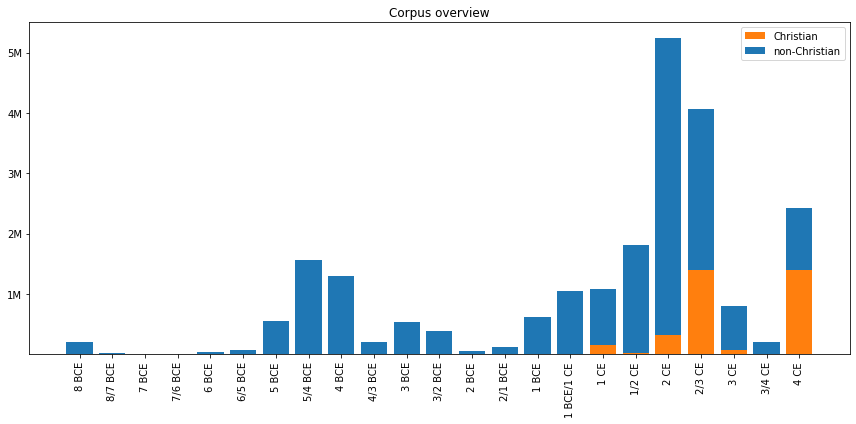

In [291]:
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
#subselections_df = subselections_df.iloc[::-1]
ax.bar(subselections_df["date_string"], subselections_df["wordcount_christian"], color="tab:orange", label="Christian")
ax.bar(subselections_df["date_string"], subselections_df["wordcount_pagan"], bottom=subselections_df["wordcount_christian"], label="non-Christian", color="tab:blue")


ax.set_yticks(range(1000000,6000000, 1000000))
ax.set_yticklabels(str(n) + "M" for n in range(1,6))
ax.set_xticklabels(subselections_df["date_string"], rotation=90)
ax.legend()
plt.title("Corpus overview")

In [292]:
sddk.write_file("SDAM_data/ECCE_public/corpus_overview.png", fig, conf)

A file with the same name ("corpus_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/corpus_overview.png"


In [293]:
def plot_ratios(corpus_df, label_col, plot_title):
  corpus_df = corpus_df[::-1]
  data = {}
  for n in range(len(corpus_df)):
    label = str(corpus_df.iloc[n][label_col]) + " (" + str(corpus_df.iloc[n]["doccount"]) + " docs; " + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][words].tolist()
    values = corpus_df.iloc[n][[word + "_weighted" for word in words]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["tab:blue", "tab:green", "tab:red"]

  terms = words


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
  plt.title(plot_title)
  return fig

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


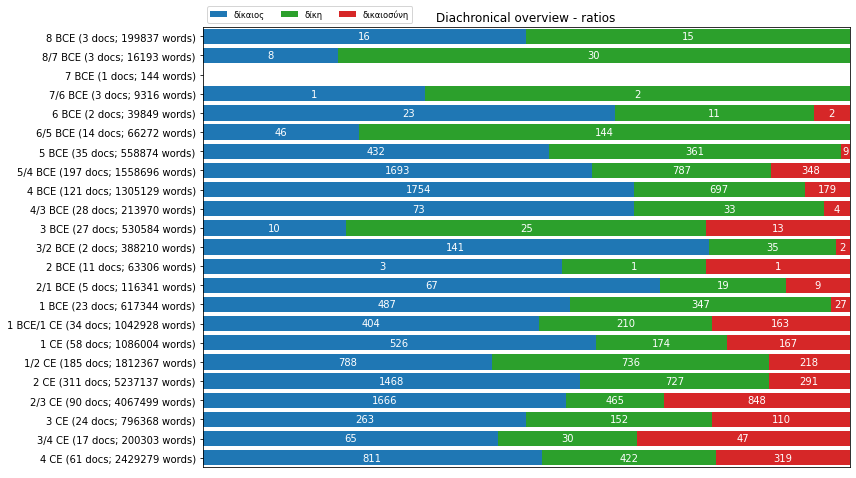

In [294]:
fig = plot_ratios(subselections_df, "date_string", "Diachronical overview - ratios")

In [295]:
sddk.write_file("SDAM_data/ECCE_public/ratios_diachronical.png", fig, conf)

A file with the same name ("ratios_diachronical.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/ratios_diachronical.png"


# Overview based on subcorpora

In [296]:
subcorpora_dict = {
    "Pagan (8th c. BCE - 4th c. CE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] < 4)],
    "Pagan (1st - 4th c. CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Septuagint" : AGT[AGT["author_id"]=="tlg0527"],
    "Philo of Alexandria" : AGT[AGT["author_id"]=="tlg0018"],
    "Titus Flavius Josephus" : AGT[AGT["author_id"]=="tlg0526"],
    "Paul of Tarsus" : AGT[AGT["author_id"]=="tlg0031paul"],
    "New Testament" : AGT[AGT["author_id"].str.startswith("tlg0031")],
    "Christian (1st - 4th c. CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}

In [297]:
subselections = []
for key in subcorpora_dict.keys():
    subselection = subcorpora_dict[key]
    subselection_dict = {}
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    subselection_dict.update({"label" : key, "wordcount" : wordcount, "doccount" : doccount})
    subselection_dict.update(count_words_in_df_column(subselection["lemmata"], words, wordcount))
    subselections.append(subselection_dict)


In [298]:
subselections_df = pd.DataFrame(subselections)
subselections_df

,label,wordcount,doccount,δίκαιος,δίκαιος_weighted,δίκη,δίκη_weighted,δικαιοσύνη,δικαιοσύνη_weighted,weighted_sum
0,Pagan (8th c. BCE - 4th c. CE),13474895,774,6078,0.00045,3465,0.00026,1149,0.00009,0.00080
1,Pagan (1st - 4th c. CE),9172125,411,2239,0.00024,1485,0.00016,615,0.00007,0.00047
2,Septuagint,872013,55,447,0.00051,45,0.00005,342,0.00039,0.00095
3,Philo of Alexandria,738272,31,370,0.00050,171,0.00023,157,0.00021,0.00094
4,Titus Flavius Josephus,469581,4,354,0.00075,157,0.00033,39,0.00008,0.00116
5,Paul of Tarsus,24066,7,14,0.00058,0,0.00000,48,0.00199,0.00257
6,New Testament,137788,27,82,0.00060,3,0.00002,90,0.00065,0.00127
7,Christian (1st - 4th c. CE),3366042,131,1917,0.00057,539,0.00016,1093,0.00032,0.00105


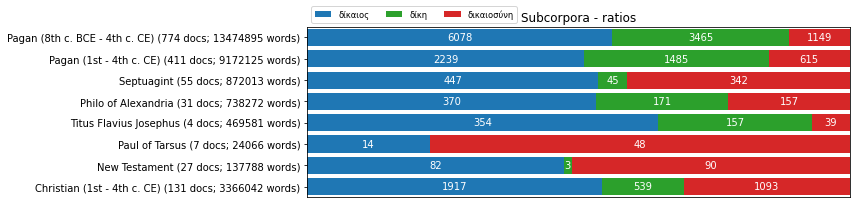

In [299]:
fig = plot_ratios(subselections_df, "label", "Subcorpora - ratios")

In [300]:
sddk.write_file("SDAM_data/ECCE_public/subcorpora_ratios.png", fig, conf)

A file with the same name ("subcorpora_ratios.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/subcorpora_ratios.png"


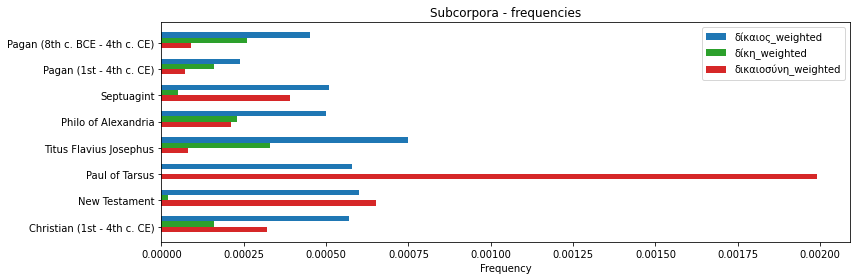

In [301]:
subselections_df = subselections_df.iloc[::-1]

fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)

y = np.arange(len(subselections_df))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, color in [("δίκαιος_weighted", "tab:blue"), ("δίκη_weighted", "tab:green"), ("δικαιοσύνη_weighted", "tab:red")]:
  #coloring = subselections_df[keyterm + "_weighted"] / subselections_df["weighted_sum"].max()
  ax.barh(y + 0.3 - bar_location, subselections_df[keyterm], width, color=color, label=keyterm)
  bar_location = bar_location + 0.2
#ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Subcorpora - frequencies")

ax.set_xlabel("Frequency")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(subselections_df["label"])

plt.legend()


In [302]:
sddk.write_file("SDAM_data/ECCE_public/subcorpora_overview.png", fig, conf)

A file with the same name ("subcorpora_overview.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/subcorpora_overview.png"


# PHI overview

In [303]:
# read the PHI dataset from sciencedata.dk
# (takes some time - the dataset has almost 400MB)
PHI = sddk.read_file("SDAM_data/PHI/PHI_dated_lemmatized_20201023.json", "df", conf)
# older version used during development: PHI = sddk.read_file("SDAM_data/PHI/PHI_enriched_raw.json", "df", conf)
# print first 5 rows of the data
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,...,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,lemmata,string_normalized
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None,"[ἔδοχσεν, τοῖος, δέμοι, τός, Σαλαμίς, κλερόχος...",ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[βολ, ℎεκον, θεός, γνοσθει, ἀτεχνος, μεδέ, ℎαμ...",ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None,"[ἀρίς, ℎερακλειο, ἀρόω, τίθημι, τός, ἀθλοθέτης...",αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None,"[ἄναξ, φροράν, πεντέκοντα, δραχμή, ἵημι, πρᾶχσ...",ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[ἔδοχσεν, τει, βολει, τοῖος, δέμοι, ℎότε, παρα...",ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...


In [262]:
len(PHI)

216702

In [178]:
PHI["wordcount"] = PHI["string_normalized"].apply(lambda string: len(string.split()))

In [179]:
PHI["wordcount"].sum()

4469462

In [267]:
len(PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())])

130533

In [180]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [181]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
PHI["random_dates"] = PHI.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min, sys: 1.07 s, total: 1min 1s
Wall time: 1min 1s


In [182]:
words = ["δίκαιος", "δίκη", "δικαιοσύνη"]
for word in words:
    PHI[word] = PHI["lemmata"].apply(lambda x: x.count(word))

In [183]:
for word in words:
    print(word, PHI[word].sum())

δίκαιος 2017
δίκη 1854
δικαιοσύνη 645


In [242]:
for word in words:
    print(PHI["string_normalized"].apply(lambda x: len(re.findall(word, x))).sum())

50
683
559


In [184]:
PHI_complete_simulations = timeblocks_from_randoms(PHI, "random_dates", [-800, 400, 50])
# look at the first one
PHI_complete_simulations[0]

[((-800, -751), 7),
 ((-750, -701), 60),
 ((-700, -651), 155),
 ((-650, -601), 272),
 ((-600, -551), 931),
 ((-550, -501), 2063),
 ((-500, -451), 3832),
 ((-450, -401), 4125),
 ((-400, -351), 6338),
 ((-350, -301), 8903),
 ((-300, -251), 8086),
 ((-250, -201), 9033),
 ((-200, -151), 8850),
 ((-150, -101), 7221),
 ((-100, -51), 4830),
 ((-50, -1), 5164),
 ((1, 50), 6017),
 ((51, 100), 6160),
 ((101, 150), 10113),
 ((151, 200), 9909),
 ((201, 250), 8907),
 ((251, 300), 5897),
 ((301, 350), 3081),
 ((351, 400), 2949)]

In [185]:
sub_df = PHI[PHI["δικαιοσύνη"]>0]
sub_df_sim = timeblocks_from_randoms(sub_df,  "random_dates", [-800, 400, 50])
sub_df_sim[0]
# for timeblock in PHI_complete_simulations[0].keys():

[((-800, -751), 0),
 ((-750, -701), 0),
 ((-700, -651), 0),
 ((-650, -601), 0),
 ((-600, -551), 0),
 ((-550, -501), 1),
 ((-500, -451), 1),
 ((-450, -401), 4),
 ((-400, -351), 31),
 ((-350, -301), 127),
 ((-300, -251), 55),
 ((-250, -201), 51),
 ((-200, -151), 26),
 ((-150, -101), 39),
 ((-100, -51), 18),
 ((-50, -1), 14),
 ((1, 50), 7),
 ((51, 100), 11),
 ((101, 150), 13),
 ((151, 200), 8),
 ((201, 250), 10),
 ((251, 300), 2),
 ((301, 350), 3),
 ((351, 400), 3)]

In [190]:
get_timeblocks(-800, 400, 50)

[(-800, -751),
 (-750, -701),
 (-700, -651),
 (-650, -601),
 (-600, -551),
 (-550, -501),
 (-500, -451),
 (-450, -401),
 (-400, -351),
 (-350, -301),
 (-300, -251),
 (-250, -201),
 (-200, -151),
 (-150, -101),
 (-100, -51),
 (-50, -1),
 (1, 50),
 (51, 100),
 (101, 150),
 (151, 200),
 (201, 250),
 (251, 300),
 (301, 350),
 (351, 400)]

In [158]:
def get_date_from_randoms(value, n):
    try:
        return value[n]
    except:
        return None

dating_variant = PHI["random_dates"].apply(lambda x: get_date_from_randoms(x, 0))
mask = dating_variant.between(200, 301)
timeblock_df_variant = PHI[mask]

In [202]:
word = "δικαιοσύνη"
complete_sim_data = []
sim_data(metrics_function):
for n in range(5):
    sim = PHI["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
    sim_data = []
    for tb in get_timeblocks(-800, 400, 50):
        mask = sim.between(tb[0], tb[1])
        df = PHI[mask]
        wordcount = df["wordcount"].sum()
        word_count = df["lemmata"].apply(lambda x: x.count(word)).sum()
        word_freq = word_count / wordcount
        sim_data.append((tb, word_freq))
    complete_sim_data.append(sim_data)

In [226]:
def tf_in_df(df, word):
    wordcount_total = df["wordcount"].sum()
    word_count = df["lemmata"].apply(lambda x: x.count(word)).sum()
    word_freq = word_count / wordcount_total
    return word_freq

In [243]:
def sim_data(df, n_sims, metrics_function, *args):
    complete_sim_data = []
    for n in range(n_sims):
        sim = df["random_dates"].apply(lambda x: get_date_from_randoms(x, n))
        sim_data = []
        for tb in get_timeblocks(-800, 400, 100):
            mask = sim.between(tb[0], tb[1])
            df_tb = PHI[mask]
            function_output = metrics_function(df_tb, *args)
            sim_data.append((tb, function_output))
        complete_sim_data.append(sim_data)
    return complete_sim_data

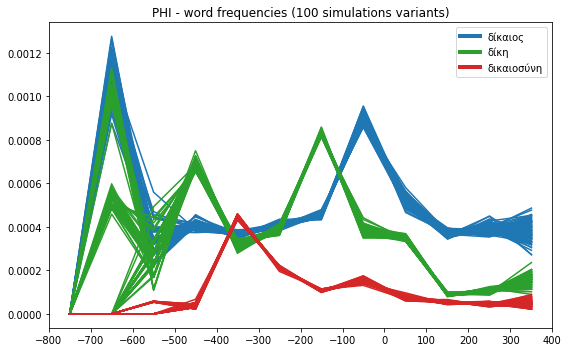

In [260]:
import matplotlib.colors as mcolors
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

import matplotlib.lines as mlines

fig, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)

markers = []

for word, color in zip(words, ["tab:blue", "tab:green", "tab:red"]):
    complete_sim_data = sim_data(PHI, 100, tf_in_df, word) 
    layer = plot_timeblocks_data(complete_sim_data, ax=ax, color=color)
    markers.append(mlines.Line2D([], [], linewidth=4, label=word, color=color))

ax.set_xlim(-800, 400)
ax.set_xticks(range(-800, 500, 100))

plt.title("PHI - word frequencies (100 simulations variants)")
ax.legend(handles=markers)

In [261]:
sddk.write_file("SDAM_data/ECCE_public/PHI_tf.png",fig, conf)

A file with the same name ("PHI_tf.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ECCE_public/PHI_tf.png"
